In [1]:
from __future__ import print_function

import numpy as np

import torch
from torch.autograd import grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display as disp

SEED = 123
%matplotlib inline

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

## Solve the following first order differential equation
## $y'=y(x)$
## where $y'=\frac{dy}{dx}$
## with the initial conditions
## $y(0)=C$.
## The solution is given by
## $y(x)=ce^{x}$

In [3]:
n = 1001
x = np.linspace(-1,1, n).reshape(n,1)
x_tensor = torch.tensor(x, device=device, dtype=torch.float, requires_grad = True)
print(x.shape)

(1001, 1)


In [4]:
D_in, H1, D_out = 1, 1000, 1
dropout = 0.01
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    nn.Dropout(dropout),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H1),
    nn.Dropout(dropout),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H1),
    nn.Dropout(dropout),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H1),
    nn.Dropout(dropout),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H1),
    nn.Dropout(dropout),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, D_out),
    nn.Dropout(dropout),
    nn.ReLU()
).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

4007001


# Define the loss function as $\sum_{i}(\frac{y^{'}_{i}}{y_{i}}-1)^2$

In [5]:
eps = 1e-14
loss_fn = nn.MSELoss(reduction='sum')

In [6]:
learning_rate = 1e-3
weight_decay = 0.1*learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

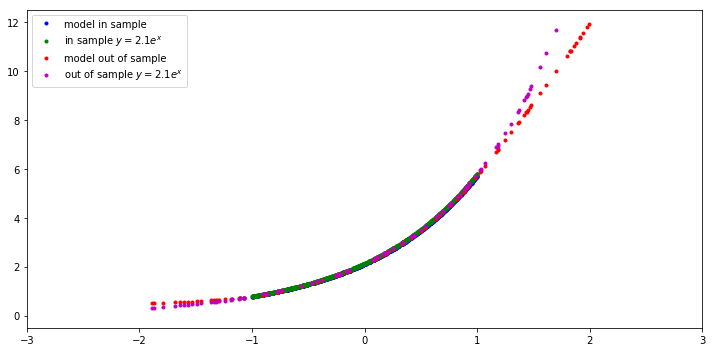

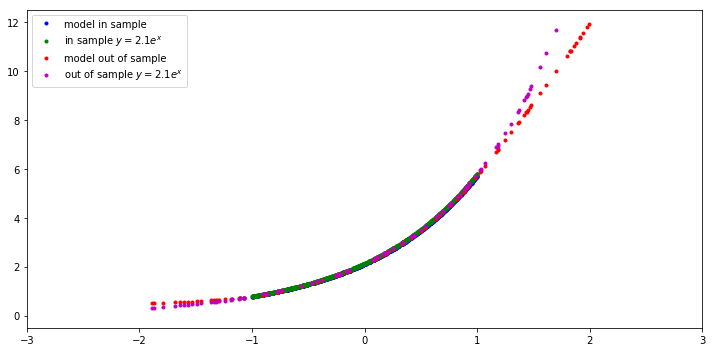

In [7]:
# y_pred, dydx = torch.zeros_like(x_tensor).to(device), torch.zeros_like(x_tensor).to(device)
c = 2.13
plt.figure(figsize=(10,5))
for t in range(100):
    model.train()
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_tensor)
    dydx, = grad(y_pred, x_tensor, grad_outputs=y_pred.data.new(y_pred.shape).fill_(1), create_graph=True)
    # Compute and print loss.
    y_hat0, c0 = model(torch.zeros_like(y_pred)), c*torch.ones_like(y_pred)
    loss = loss_fn(dydx, y_pred+eps) + loss_fn(y_hat0, c0)

    optimizer.zero_grad()    
    loss.backward(retain_graph=True)
    optimizer.step()

    x = np.sort(np.random.uniform(-1, 1, (n,1)))
    x_tensor = torch.tensor(x, device=device, dtype=torch.float, requires_grad = True)
    if t%1==0:
        model.eval()
        
        plt.gca().cla()
        plt.plot(x, model(x_tensor).cpu().data.numpy(), 'b.', label='model in sample')
        plt.plot(x, c*np.exp(x), 'g.', label=r'in sample $y=%.1fe^{x}$'%c);
        
        a = np.sort(np.random.uniform(-2, 2, (100,1)))
        at = torch.from_numpy(a).float().to(device)
        bt = model(at)
        plt.plot(a, bt.cpu().data.numpy(), 'r.', label='model out of sample');
        plt.plot(a, c*np.exp(a), 'm.', label=r'out of sample $y=%.1fe^{x}$'%c);
        plt.xlim([-3,3])
        plt.ylim([-0.5,12.5])
        plt.tight_layout()
        plt.legend()

        disp.clear_output(wait=True)
        disp.display(plt.gcf())
        

## Now let's learn a simpler equation
## $y'x=y$
## with the initial conditions
## $y(1)=c$
## The solution is given by
## $y(x)=cx$

In [8]:
D_in, H1, D_out = 1, 300, 1
dropout = 0.5
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    nn.Dropout(dropout),
    torch.nn.Linear(H1, H1),
    nn.Dropout(dropout),
    torch.nn.Linear(H1, D_out),
).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

91201


In [9]:
n = 1001
x = np.linspace(-1,1, n).reshape(n,1)
x_tensor = torch.tensor(x, device=device, dtype=torch.float, requires_grad=True)
print(x.shape)

(1001, 1)


In [10]:
eps = 1e-14
loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1e-3
weight_decay = 0.1*learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

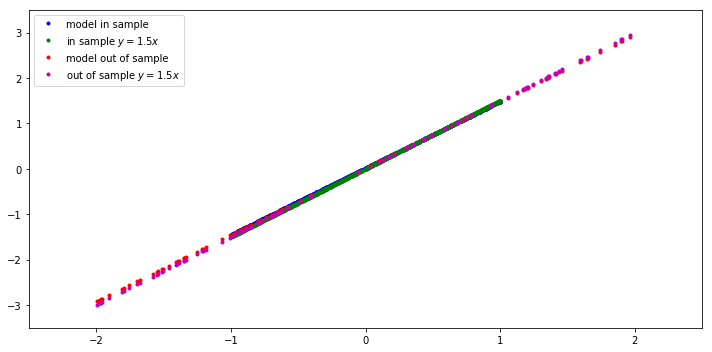

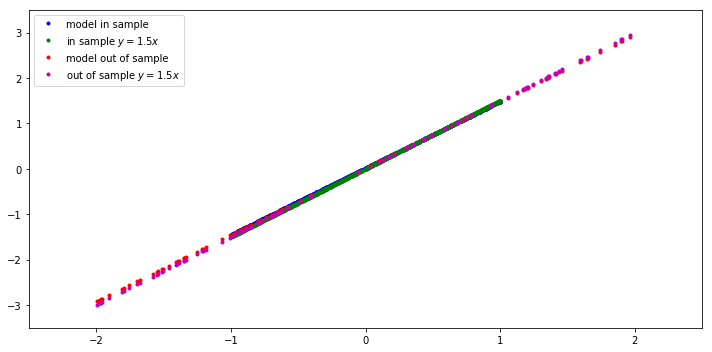

In [11]:
c = 1.5
plt.figure(figsize=(10,5))
for t in range(100):
    model.train()
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_tensor)
    dydx, = grad(y_pred, x_tensor, grad_outputs=y_pred.data.new(y_pred.shape).fill_(1), create_graph=True)
    # Compute and print loss.
    y_hat0, c0 = model(torch.ones_like(y_pred)), c*torch.ones_like(y_pred)
    loss = loss_fn(dydx*x_tensor, y_pred+eps) + loss_fn(y_hat0, c0)

    optimizer.zero_grad()    
    loss.backward(retain_graph=True)
    optimizer.step()

    x = np.sort(np.random.uniform(-1, 1, (n,1)))
    x_tensor = torch.tensor(x, device=device, dtype=torch.float, requires_grad = True)
    if t%1==0:
        model.eval()
        
        plt.gca().cla()
        plt.plot(x, model(x_tensor).cpu().data.numpy(), 'b.', label='model in sample')
        plt.plot(x, c*x, 'g.', label=r'in sample $y=%.1fx$'%c);
        
        a = np.sort(np.random.uniform(-2, 2, (100,1)))
        at = torch.from_numpy(a).float().to(device)
        bt = model(at)
        plt.plot(a, bt.cpu().data.numpy(), 'r.', label='model out of sample');
        plt.plot(a, c*a, 'm.', label=r'out of sample $y=%.1fx$'%c);
        plt.ylim([-3.5,3.5])
        plt.xlim([-2.5,2.5])
        plt.tight_layout()
        plt.legend()

        disp.clear_output(wait=True)
        disp.display(plt.gcf())
        

## Looks good enough
## But can a neural network learn a more complicated functions like
## $y'=\cos(X)$
## The solution is of course
## $y(x) = \sin(x) + c$

In [12]:
D_in, H1, D_out = 1, 1000, 1
dropout = 0.05
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    nn.Dropout(dropout),
    torch.nn.SELU(),
    torch.nn.Linear(H1, H1*2),
    nn.Dropout(dropout),
    torch.nn.SELU(),
    torch.nn.Linear(H1*2, H1*2),
    nn.Dropout(dropout),
    torch.nn.SELU(),
    torch.nn.Linear(H1*2, H1),
    nn.Dropout(dropout),
    torch.nn.SELU(),
    torch.nn.Linear(H1, H1),
    nn.Dropout(dropout),
    torch.nn.SELU(),
    torch.nn.Linear(H1, D_out),
).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

9009001


In [13]:
n = 1001
x = np.linspace(-1,1, n).reshape(n,1)
x_tensor = torch.tensor(x, device=device, dtype=torch.float, requires_grad=True)
print(x.shape)

(1001, 1)


In [14]:
eps = 1e-14
loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1e-5
weight_decay = 0.1*learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

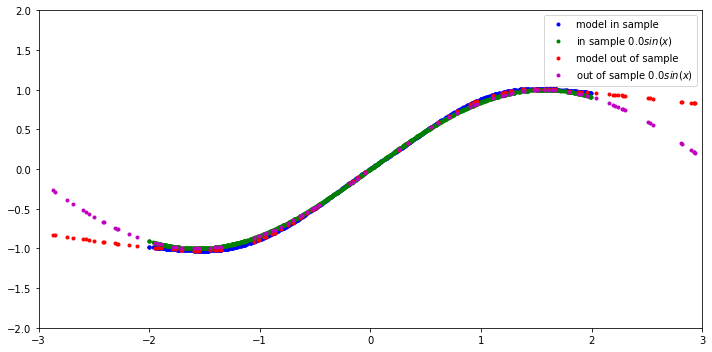

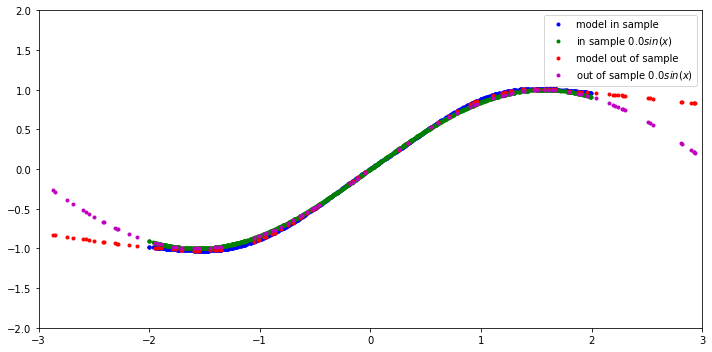

In [15]:
c = 0.
plt.figure(figsize=(10,5))
for t in range(100):
    model.train()
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_tensor)
    dydx, = grad(y_pred, x_tensor, grad_outputs=y_pred.data.new(y_pred.shape).fill_(1), create_graph=True)
    # Compute and print loss.
    y_hat0, c0 = model(torch.zeros_like(y_pred)), c*torch.ones_like(y_pred)
    loss = loss_fn(dydx, torch.cos(x_tensor)) + loss_fn(y_hat0, c0)

    optimizer.zero_grad()    
    loss.backward(retain_graph=True)
    optimizer.step()

    x = np.sort(np.random.uniform(-2, 2, (n,1)))
    x_tensor = torch.tensor(x, device=device, dtype=torch.float, requires_grad = True)
    if t%1==0:
        model.eval()
        
        plt.gca().cla()
        plt.plot(x, model(x_tensor).cpu().data.numpy(), 'b.', label='model in sample')
        plt.plot(x, np.sin(x)+c, 'g.', label=r'in sample $%.1fsin(x)$'%c);
        
        a = np.sort(np.random.uniform(-np.pi, np.pi, (100,1)))
        at = torch.from_numpy(a).float().to(device)
        bt = model(at)
        plt.plot(a, bt.cpu().data.numpy(), 'r.', label='model out of sample');
        plt.plot(a, np.sin(a)+c, 'm.', label=r'out of sample $%.1fsin(x)$'%c);
        plt.xlim([-3,3])
        plt.ylim([-2.0,2.0])
        plt.tight_layout()
        plt.legend()

        disp.clear_output(wait=True)
        disp.display(plt.gcf())
        